# 8. Machine Learning Models for Geospatial
## 8.1 Preparation
#### 8.1.1 Feature Engineering

In [24]:
import numpy as np

#### 8.2 Model Specification

In [38]:
# from sklearn.datasets.california_housing import fetch_california_housing
# from sklearn.cross_validation import train_test_split
# FIGSIZE = (11, 7)
# cal_housing = fetch_california_housing()
# cal_housing
# # split 80/20 train-test
# X_train, X_test, y_train, y_test = train_test_split(cal_housing.data,
#                                                     cal_housing.target,
#                                                     test_size=0.2,
#                                                     random_state=1)
# names = cal_housing.feature_names
cal_housing

{'DESCR': 'California housing dataset.\n\nThe original database is available from StatLib\n\n    http://lib.stat.cmu.edu/\n\nThe data contains 20,640 observations on 9 variables.\n\nThis dataset contains the average house value as target variable\nand the following input variables (features): average income,\nhousing average age, average rooms, average bedrooms, population,\naverage occupation, latitude, and longitude in that order.\n\nReferences\n----------\n\nPace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,\nStatistics and Probability Letters, 33 (1997) 291-297.\n\n',
 'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ..., 
        [   1.7       ,   17.        ,    

In [7]:
import pandas as pd
X_df = pd.DataFrame(data=X_train, columns=names)
X_df['MedHouseVal'] = y_train
_ = X_df.hist(column=['Latitude', 'Longitude', 'MedInc', 'MedHouseVal'], figsize=FIGSIZE)

In [22]:
def deviance_plot(est, X_test, y_test, ax=None, label='', train_color='#2c7bb6', 
                  test_color='#d7191c', alpha=1.0, ylim=(0, 10)):
    """Deviance plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
    n_estimators = len(est.estimators_)
    test_dev = np.empty(n_estimators)

    for i, pred in enumerate(est.staged_predict(X_test)):
       test_dev[i] = est.loss_(y_test, pred)

    if ax is None:
        fig = plt.figure(figsize=FIGSIZE)
        ax = plt.gca()
        
    ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label, 
             linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color=train_color, 
             label='Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    ax.set_ylim(ylim)
    return test_dev, ax

In [14]:
import time
from sklearn.ensemble import GradientBoostingRegressor
from collections import defaultdict
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR

res = defaultdict(dict)

def benchmark(est, name=None):
    if not name:
        name = est.__class__.__name__
    t0 = time.clock()
    est.fit(X_train, y_train)
    res[name]['train_time'] = time.clock() - t0
    t0 = time.clock()
    pred = est.predict(X_test)
    res[name]['test_time'] = time.clock() - t0
    res[name]['MAE'] = mean_absolute_error(y_test, pred)
    return est
    
benchmark(DummyRegressor())
benchmark(Ridge(alpha=0.0001, normalize=True))
benchmark(Pipeline([('std', StandardScaler()), 
                    ('svr', SVR(kernel='rbf', C=10.0, gamma=0.1, tol=0.001))]), name='SVR')
benchmark(RandomForestRegressor(n_estimators=100, max_features=5, random_state=0, 
                                bootstrap=False, n_jobs=4))
est = benchmark(GradientBoostingRegressor(n_estimators=500, max_depth=4, learning_rate=0.1,
                                          loss='huber', min_samples_leaf=3, 
                                          random_state=0))

res_df = pd.DataFrame(data=res).T
res_df[['train_time', 'test_time', 'MAE']].sort('MAE', ascending=False)

/home/tankofvines/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:37: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,train_time,test_time,MAE
DummyRegressor,0.000926,0.000137,0.909090
Ridge,0.004321,0.000321,0.532860
SVR,20.237027,1.461607,0.379575
RandomForestRegressor,14.677222,0.174439,0.318237
GradientBoostingRegressor,8.383507,0.033413,0.300730


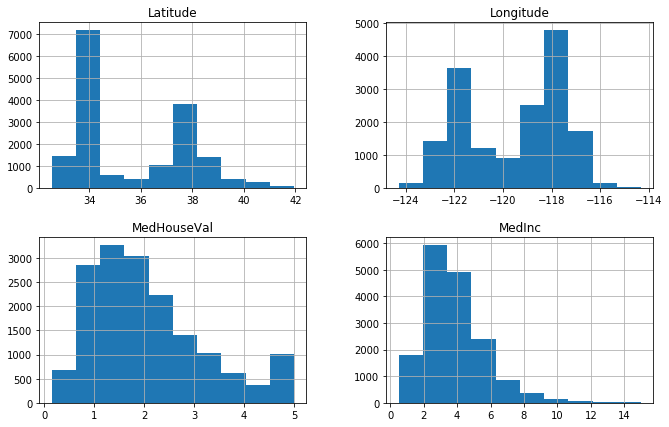

In [33]:
% matplotlib inline
import pandas as pd
X_df = pd.DataFrame(data=X_train, columns=names)
X_df['MedHouseVal'] = y_train
_ = X_df.hist(column=['Latitude', 'Longitude', 'MedInc', 'MedHouseVal'], figsize=FIGSIZE)

/home/tankofvines/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  app.launch_new_instance()


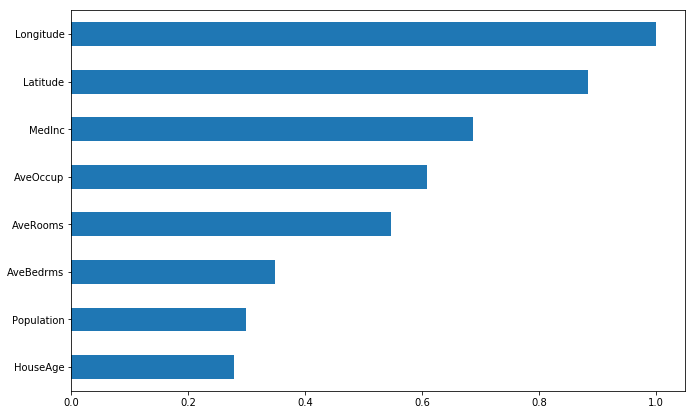

In [34]:
fx_imp = pd.Series(est.feature_importances_, index=names)
fx_imp /= fx_imp.max()  # normalize
fx_imp.sort()
fx_imp.plot(kind='barh', figsize=FIGSIZE)

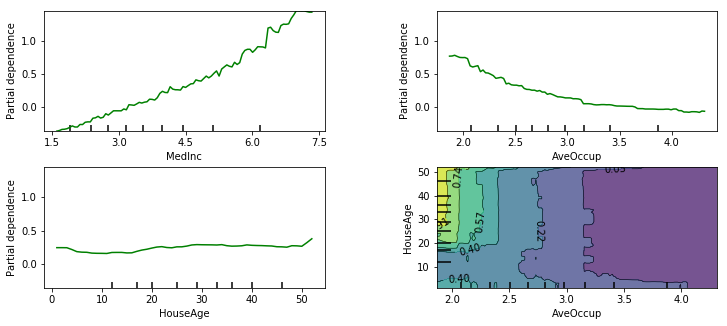

In [35]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

features = ['MedInc', 'AveOccup', 'HouseAge',
            ('AveOccup', 'HouseAge')]
fig, axs = plot_partial_dependence(est, X_train, features, feature_names=names, 
                                   n_cols=2, figsize=FIGSIZE)